# Phase 3: Train Mamba-UNet on Landcover.ai Dataset

**Goal**: Train MambaUNet on real aerial imagery and compare with ResNet_UNet baseline

**Dataset**: Landcover.ai v1 (41 GeoTIFFs, 512×512 tiles, 5 land cover classes)


## 1: Setup and Imports

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
import warnings
# warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

PyTorch: 2.4.1+cu121
CUDA available: True
Device: NVIDIA GeForce RTX 4060
Memory: 8.0 GB

Using device: cuda


## 2: Load MambaUNet Architecture (from 02_build_mamba_unet.ipynb)

In [2]:
from mamba_ssm import Mamba

class PatchEmbedding(nn.Module):
    """Convert image to patch tokens."""
    def __init__(self, patch_size=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, 32, 32)
        x = x.flatten(2)   # (B, embed_dim, 1024)
        x = x.transpose(1, 2)  # (B, 1024, embed_dim)
        return x


class MambaEncoder(nn.Module):
    """Mamba encoder with pre-norm residual architecture."""
    def __init__(self, dim=128, num_layers=3):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.ModuleDict({
                'norm': nn.LayerNorm(dim),
                'mamba': Mamba(d_model=dim, d_state=16, d_conv=4, expand=2),
            }))
    
    def forward(self, x):
        for layer_dict in self.layers:
            x_norm = layer_dict['norm'](x)
            x = x + layer_dict['mamba'](x_norm)
        return x


class Decoder(nn.Module):
    """Decoder to upsample patches back to image resolution."""
    def __init__(self, dim=128, num_classes=1):
        super().__init__()
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.upsample4 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.out = nn.Conv2d(8, num_classes, kernel_size=1)
    
    def forward(self, x):
        B = x.shape[0]
        x = x.transpose(1, 2)  # (B, 128, 1024)
        x = x.reshape(B, 128, 32, 32)  # (B, 128, 32, 32)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        x = self.out(x)  # (B, num_classes, 512, 512)
        return x


class MambaUNet(nn.Module):
    """Complete Mamba-UNet for segmentation."""
    def __init__(self, patch_size=16, embed_dim=128, num_mamba_layers=3, num_classes=1, input_image_size=512):
        super().__init__()
        self.input_image_size = input_image_size
        self.num_classes = num_classes
        self.patch_embed = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)
        self.encoder = MambaEncoder(dim=embed_dim, num_layers=num_mamba_layers)
        self.decoder = Decoder(dim=embed_dim, num_classes=num_classes)
    
    def forward(self, x):
        x = self.patch_embed(x)  # (B, 1024, 128)
        x = self.encoder(x)  # (B, 1024, 128)
        x = self.decoder(x)  # (B, num_classes, 512, 512)
        return x


print("\n✓ MambaUNet architecture loaded")
print(f"Total params: {sum(p.numel() for p in MambaUNet().parameters()):,}")


✓ MambaUNet architecture loaded
Total params: 622,849


## 3: Define Dataset Class

In [3]:
class LandcoverAIDataset(Dataset):
    """Load Landcover.ai dataset with 512x512 tile extraction."""
    
    def __init__(self, root_dir, split_file):
        self.root_dir = Path(root_dir)
        self.images_dir = self.root_dir / 'images'
        self.masks_dir = self.root_dir / 'masks'
        
        # Load tile names from split file
        with open(split_file, 'r') as f:
            self.tile_names = [line.strip() for line in f if line.strip()] # removes blanks
        
        print(f"Loaded {len(self.tile_names)} tile names from {split_file}")
    
    def __len__(self):
        return len(self.tile_names)
    
    def __getitem__(self, idx):
        tile_name = self.tile_names[idx]
        # Parse: "filename_tile_number"
        parts = tile_name.rsplit('_', 1)
        if len(parts) == 2:
            image_name, tile_num = parts
            tile_num = int(tile_num)
        else:
            image_name = tile_name
            tile_num = 0
        
        image_path = self.images_dir / f"{image_name}.tif"
        mask_path = self.masks_dir / f"{image_name}.tif"
        
        # Load with rasterio
        with rasterio.open(image_path) as src:
            image_full = src.read()  # (C, H, W)
        with rasterio.open(mask_path) as src:
            mask_full = src.read(1)  # (H, W)
        
        # Extract 512x512 tile
        tile_size = 512
        H, W = image_full.shape[1], image_full.shape[2]
        tiles_per_row = W // tile_size
        tile_row = tile_num // tiles_per_row
        tile_col = tile_num % tiles_per_row
        
        y_start = min(tile_row * tile_size, H - tile_size)
        x_start = min(tile_col * tile_size, W - tile_size)
        y_end = y_start + tile_size
        x_end = x_start + tile_size
        
        image_tile = image_full[:, y_start:y_end, x_start:x_end]  # (3, 512, 512)
        mask_tile = mask_full[y_start:y_end, x_start:x_end]  # (512, 512)
        
        # Convert to torch and normalize
        image = torch.from_numpy(image_tile).float() / 255.0
        mask = torch.from_numpy(mask_tile).long()
        
        # ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        image = (image - mean) / std
        
        return image, mask

print("✓ LandcoverAIDataset class defined")

✓ LandcoverAIDataset class defined


## 4: Load Datasets

In [4]:
print("\n=== Loading Datasets ===\n")

dataset_root = Path('landcover.ai.v1')

# Verify dataset exists
print(f"Dataset root: {dataset_root}")
print(f"Images dir exists: {(dataset_root / 'images').exists()}")
print(f"Masks dir exists: {(dataset_root / 'masks').exists()}")
print(f"Train split exists: {(dataset_root / 'train.txt').exists()}")
print(f"Val split exists: {(dataset_root / 'val.txt').exists()}")
print(f"Test split exists: {(dataset_root / 'test.txt').exists()}")

# Load datasets
print()
train_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'train.txt')
val_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'val.txt')
test_dataset = LandcoverAIDataset(dataset_root, dataset_root / 'test.txt')

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,} tiles")
print(f"  Val:   {len(val_dataset):,} tiles")
print(f"  Test:  {len(test_dataset):,} tiles")
print(f"  Total: {len(train_dataset) + len(val_dataset) + len(test_dataset):,} tiles")


=== Loading Datasets ===

Dataset root: landcover.ai.v1
Images dir exists: True
Masks dir exists: True
Train split exists: True
Val split exists: True
Test split exists: True

Loaded 7470 tile names from landcover.ai.v1/train.txt
Loaded 1602 tile names from landcover.ai.v1/val.txt
Loaded 1602 tile names from landcover.ai.v1/test.txt

Dataset sizes:
  Train: 7,470 tiles
  Val:   1,602 tiles
  Test:  1,602 tiles
  Total: 10,674 tiles


## 5: Create DataLoaders

In [5]:
print("\n=== Creating DataLoaders ===\n")

batch_size = 8
num_workers = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

print(f"Batch size: {batch_size}")
print(f"Num workers: {num_workers}")
print(f"\nTrain batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")
print(f"Test batches:  {len(test_loader):,}")


=== Creating DataLoaders ===

Batch size: 8
Num workers: 4

Train batches: 934
Val batches:   201
Test batches:  201


## 6: Verify Data Shapes and Quality

In [6]:
print("\n=== Verifying Data Shapes ===\n")

first_batch = next(iter(train_loader))
x, y = first_batch

print(f"Image batch shape: {x.shape}")
print(f"  Expected: (8, 3, 512, 512) ✓" if x.shape == (8, 3, 512, 512) else "  ERROR!")

print(f"\nMask batch shape:  {y.shape}")
print(f"  Expected: (8, 512, 512) ✓" if y.shape == (8, 512, 512) else "  ERROR!")

# Check value ranges
print(f"\nImage value range: [{x.min():.3f}, {x.max():.3f}]")
print(f"Mask value range:  [{y.min()}, {y.max()}]")
print(f"Mask unique values: {sorted(torch.unique(y).tolist())}")

# Check for NaN/Inf
has_nan = torch.isnan(x).any()
has_inf = torch.isinf(x).any()
print(f"\nImage has NaN: {has_nan}")
print(f"Image has Inf: {has_inf}")

if not has_nan and not has_inf:
    print("\n✓ Data quality check passed!")
else:
    print("\n✗ WARNING: Data contains NaN/Inf")


=== Verifying Data Shapes ===

Image batch shape: torch.Size([8, 3, 512, 512])
  Expected: (8, 3, 512, 512) ✓

Mask batch shape:  torch.Size([8, 512, 512])
  Expected: (8, 512, 512) ✓

Image value range: [-2.118, 2.152]
Mask value range:  [0, 4]
Mask unique values: [0, 1, 2, 3, 4]

Image has NaN: False
Image has Inf: False

✓ Data quality check passed!


## 7: Visualize Sample Data


=== Visualizing Samples ===



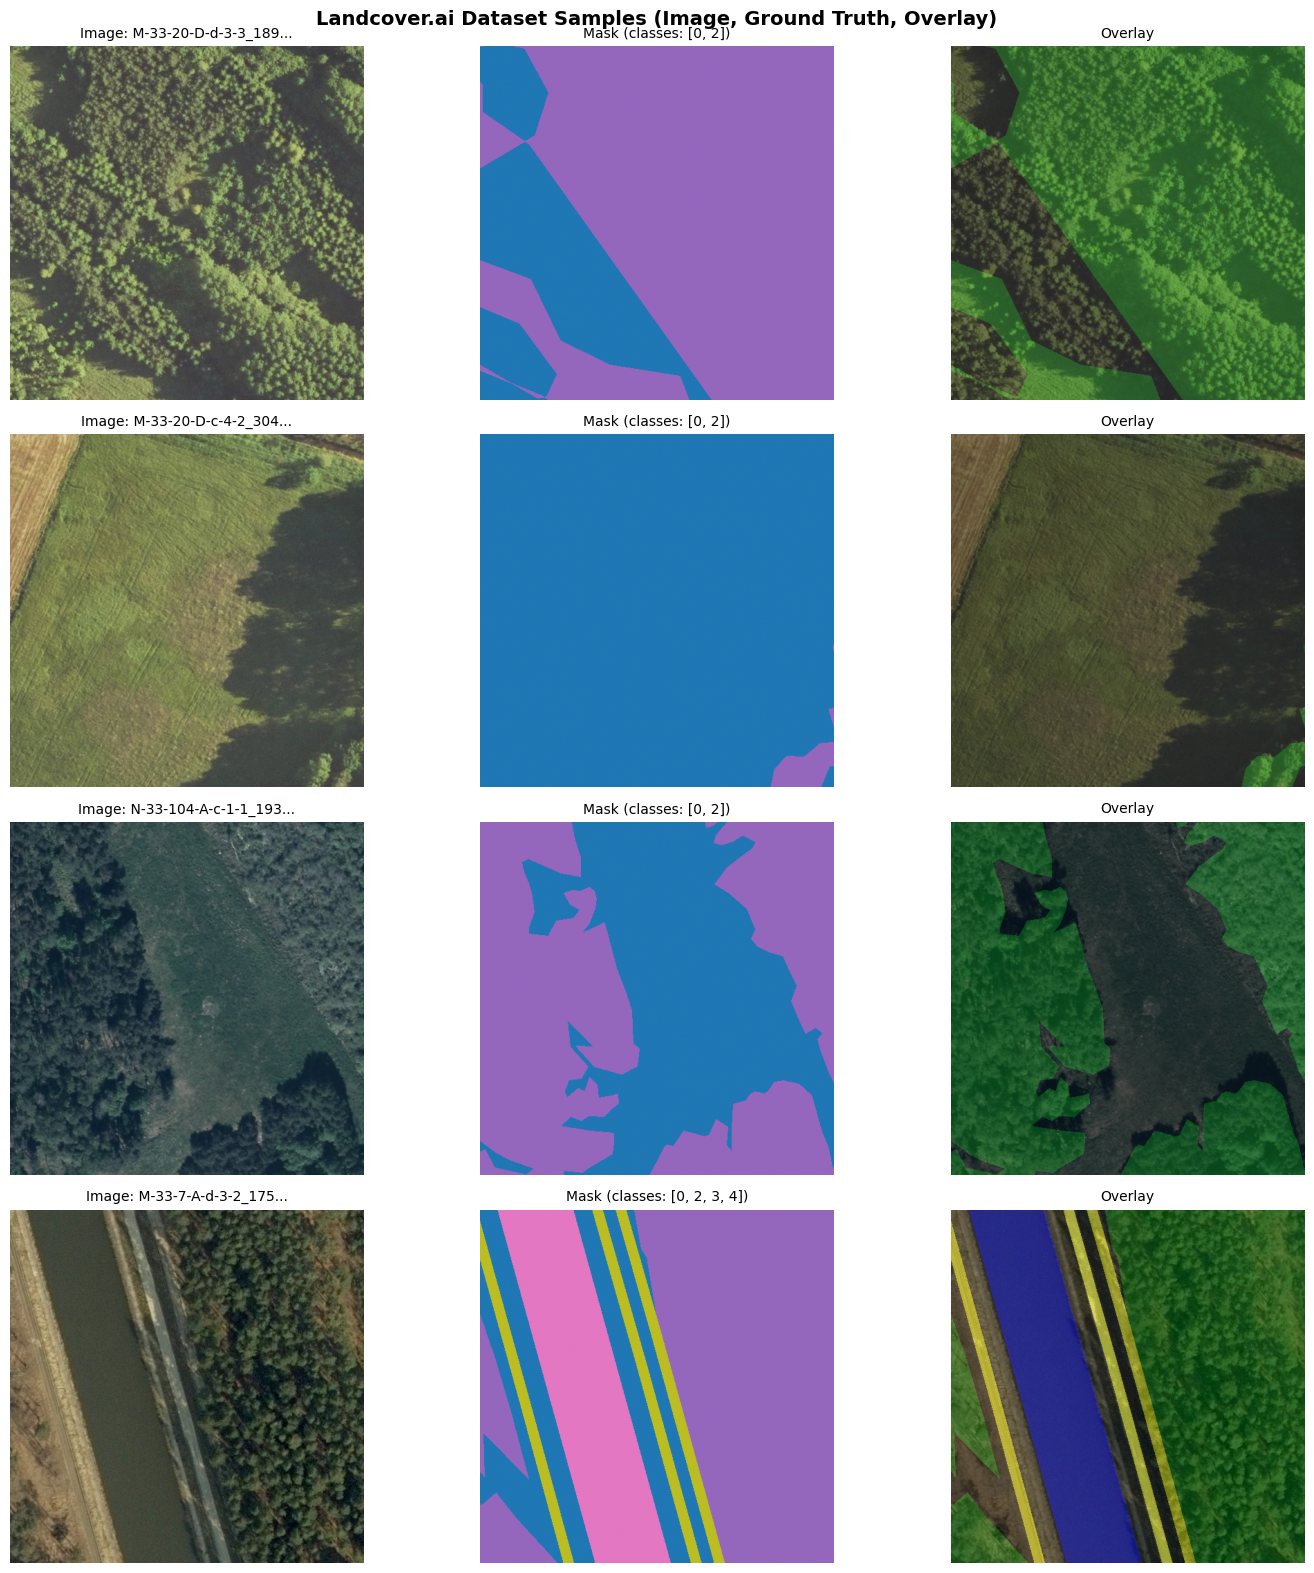

✓ Saved data_samples.png


In [7]:
print("\n=== Visualizing Samples ===\n")

# Get 4 random samples from training set
sample_indices = np.random.choice(len(train_dataset), 4, replace=False)
samples = [train_dataset[i] for i in sample_indices]

# Denormalization function (reverse ImageNet norm)
def denormalize(img):
    """Reverse ImageNet normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    img = img * std + mean
    return torch.clamp(img, 0, 1)

# Create visualization
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('Landcover.ai Dataset Samples (Image, Ground Truth, Overlay)', fontsize=14, fontweight='bold')

# Class color mapping
class_colors = {
    0: [0.0, 0.0, 0.0],      # Background - black
    1: [1.0, 0.0, 0.0],      # Building - red
    2: [0.0, 0.5, 0.0],      # Woodland - dark green
    3: [0.0, 0.0, 1.0],      # Water - blue
    4: [1.0, 1.0, 0.0],      # Road - yellow
}

for row in range(len(samples)):
    img, mask = samples[row]
    tile_name = train_dataset.tile_names[sample_indices[row]]
    
    # Denormalize image
    img_denorm = denormalize(img).numpy().transpose(1, 2, 0)
    mask_np = mask.numpy()
    
    # Row 1: Original image
    axes[row, 0].imshow(img_denorm)
    axes[row, 0].set_title(f'Image: {tile_name[:25]}...', fontsize=10)
    axes[row, 0].axis('off')
    
    # Row 2: Mask
    axes[row, 1].imshow(mask_np, cmap='tab10', vmin=0, vmax=5)
    axes[row, 1].set_title(f'Mask (classes: {sorted(np.unique(mask_np).tolist())})', fontsize=10)
    axes[row, 1].axis('off')
    
    # Row 3: Overlay (mask as colored overlay on image)
    mask_rgb = np.zeros((*mask_np.shape, 3))
    for class_id, color in class_colors.items():
        mask_rgb[mask_np == class_id] = color
    
    overlay = 0.6 * img_denorm + 0.4 * mask_rgb
    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title('Overlay', fontsize=10)
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig('data_samples.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved data_samples.png")

## 8: Analyze Class Distribution

In [8]:
print("\n=== Dataset Statistics ===\n")

# Count class distribution in training set
class_counts = {i: 0 for i in range(5)}
total_pixels = 0

print("Counting class distribution in first 100 training tiles...")
for i in range(min(100, len(train_dataset))):
    img, mask = train_dataset[i]
    for class_id in range(5):
        class_counts[class_id] += (mask == class_id).sum().item()
    total_pixels += mask.numel()
    if (i + 1) % 25 == 0:
        print(f"  Processed {i + 1} tiles...")

class_names = {0: 'Background', 1: 'Building', 2: 'Woodland', 3: 'Water', 4: 'Road'}

print(f"\nClass distribution:")
for class_id in range(5):
    pct = (class_counts[class_id] / total_pixels * 100) if total_pixels > 0 else 0
    print(f"  {class_id} ({class_names[class_id]:10s}): {class_counts[class_id]:>10,} pixels ({pct:>5.1f}%)")

print(f"\nTotal pixels sampled: {total_pixels:,}")
print("\n✓ Data loading complete! Ready for training.")


=== Dataset Statistics ===

Counting class distribution in first 100 training tiles...
  Processed 25 tiles...
  Processed 50 tiles...
  Processed 75 tiles...
  Processed 100 tiles...

Class distribution:
  0 (Background):  4,870,416 pixels ( 18.6%)
  1 (Building  ):      5,401 pixels (  0.0%)
  2 (Woodland  ): 17,396,494 pixels ( 66.4%)
  3 (Water     ):  3,727,317 pixels ( 14.2%)
  4 (Road      ):    214,772 pixels (  0.8%)

Total pixels sampled: 26,214,400

✓ Data loading complete! Ready for training.


## 9: Import TrainingSession and Loss Functions

In [9]:
# Import from project directory
sys.path.insert(0, '../../')

from models import JaccardLoss, ResNet_UNet
from training_utils import TrainingSession

print("✓ Imported TrainingSession and loss functions")

✓ Imported TrainingSession and loss functions


## 10: Create Weighted Loss Function

In [10]:
print("\n=== Setting Up Loss Function ===\n")

# Class distribution from analysis: [18.6%, 0.0%, 66.4%, 14.2%, 0.8%]
# Use inverse frequency weighting: weight = 1 / frequency
class_dist = torch.tensor([0.186, 0.0001, 0.664, 0.142, 0.008])
class_weights = (1.0 / class_dist).float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)  # Move to GPU

print(f"Class frequencies:  {[f'{x:.3f}' for x in class_dist.tolist()]}")
print(f"Normalized weights: {[f'{x:.4f}' for x in class_weights.tolist()]}")

# NOTE: Using CrossEntropyLoss instead of JaccardLoss to avoid dtype mismatch during mixed precision training
# JaccardLoss combines 50% CE + 50% IoU loss for better segmentation optimization, but requires dtype handling

# loss_fn = JaccardLoss(num_classes=5, weight=class_weights, alpha=0.5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
print(f"\n✓ Loss function: CrossEntropyLoss (5-class, weighted)")


=== Setting Up Loss Function ===

Class frequencies:  ['0.186', '0.000', '0.664', '0.142', '0.008']
Normalized weights: ['0.0005', '0.9863', '0.0001', '0.0007', '0.0123']

✓ Loss function: CrossEntropyLoss (5-class, weighted)


## 11: Initialize Models

In [11]:
print("\n=== Initializing Models ===\n")

# Initialize MambaUNet with 5 classes
mamba_model = MambaUNet(
    patch_size=16, embed_dim=128, num_mamba_layers=3,
    num_classes=5, input_image_size=512
).to(device)

mamba_params = sum(p.numel() for p in mamba_model.parameters())
print(f"MambaUNet:")
print(f"  Parameters: {mamba_params:,}")
print(f"  Device: {device}")

# Initialize ResNet_UNet baseline
resnet_model = ResNet_UNet(input_image_size=512, num_classes=5).to(device)
resnet_params = sum(p.numel() for p in resnet_model.parameters())
print(f"\nResNet_UNet:")
print(f"  Parameters: {resnet_params:,}")
print(f"  Device: {device}")

print(f"\nParameter comparison:")
print(f"  MambaUNet:   {mamba_params:,} ({mamba_params / (10**6):.2f}M)")
print(f"  ResNet_UNet: {resnet_params:,} ({resnet_params / (10**6):.2f}M)")
print(f"  Ratio: {resnet_params / mamba_params:.1f}x larger (ResNet)")


=== Initializing Models ===

MambaUNet:
  Parameters: 622,885
  Device: cuda

ResNet_UNet:
  Parameters: 15,908,650
  Device: cuda

Parameter comparison:
  MambaUNet:   622,885 (0.62M)
  ResNet_UNet: 15,908,650 (15.91M)
  Ratio: 25.5x larger (ResNet)


## 12: Train MambaUNet

2025-11-12 19:11:14,780 - INFO - Starting training: 2 epochs
2025-11-12 19:11:14,781 - INFO - Model parameters: 622,885



TRAINING MAMBAUNET
Using CUDA device.


Epoch 1/2: 100%|██████████| 934/934 [1:16:55<00:00,  4.94s/it, loss=0.5297, lr=0.000100]
2025-11-12 20:45:15,645 - INFO - Epoch   1 | Train Loss: 0.9975 | Val Loss: 1.1784 | Avg Metric: 0.0969
2025-11-12 20:45:15,649 - INFO -   Dataset 1: {'Pixel_Accuracy': 0.44318432831645604, 'Precision': 0.12474311827223314, 'Recall': 0.22942796355888107, 'IOU': 0.09694295761076574, 'class_ious': [0.453395792232729, 0.03131832919139716, 0.0, 0.0, 6.666297026210817e-07], 'class_precisions': [0.5606513818713201, 0.03238427572599071, 0.0, 0.0, 0.03067993376385513], 'class_recalls': [0.7179641121887227, 0.42917503896910714, 0.0, 0.0, 6.666365758671114e-07], 'Loss': 1.1783647269232949}
2025-11-12 20:45:15,768 - INFO - New best model saved at epoch 1


Epoch   1 | Train Loss: 0.9975 | Val Loss: 1.1784 | Avg Metric: 0.0969


Epoch 2/2: 100%|██████████| 934/934 [1:17:34<00:00,  4.98s/it, loss=2.0964, lr=0.000050]
2025-11-12 22:20:02,703 - INFO - Epoch   2 | Train Loss: 0.6879 | Val Loss: 0.9490 | Avg Metric: 0.1127
2025-11-12 22:20:02,706 - INFO -   Dataset 1: {'Pixel_Accuracy': 0.5015911747567097, 'Precision': 0.15021714104787406, 'Recall': 0.2519844002767872, 'IOU': 0.11267214436392628, 'class_ious': [0.5249517926093729, 0.03840677312406449, 0.0, 1.5235497102280962e-06, 6.325364837771055e-07], 'class_precisions': [0.5978222220617148, 0.03908001423889203, 0.0, 0.08350353517490833, 0.03067993376385513], 'class_recalls': [0.8117931956675515, 0.44812664956744036, 0.0, 1.5236089359800938e-06, 6.32540008634681e-07], 'Loss': 0.9490261389248407}
2025-11-12 22:20:02,870 - INFO - New best model saved at epoch 2
2025-11-12 22:20:02,873 - INFO - Training completed! Best metric: 0.1127 at epoch 2


Epoch   2 | Train Loss: 0.6879 | Val Loss: 0.9490 | Avg Metric: 0.1127


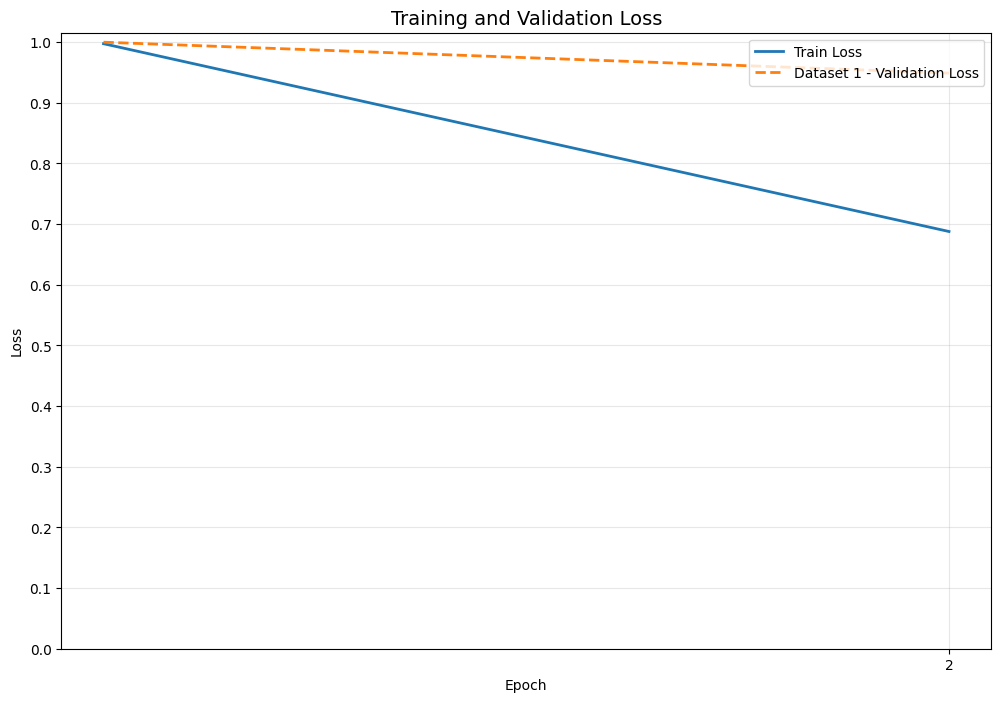

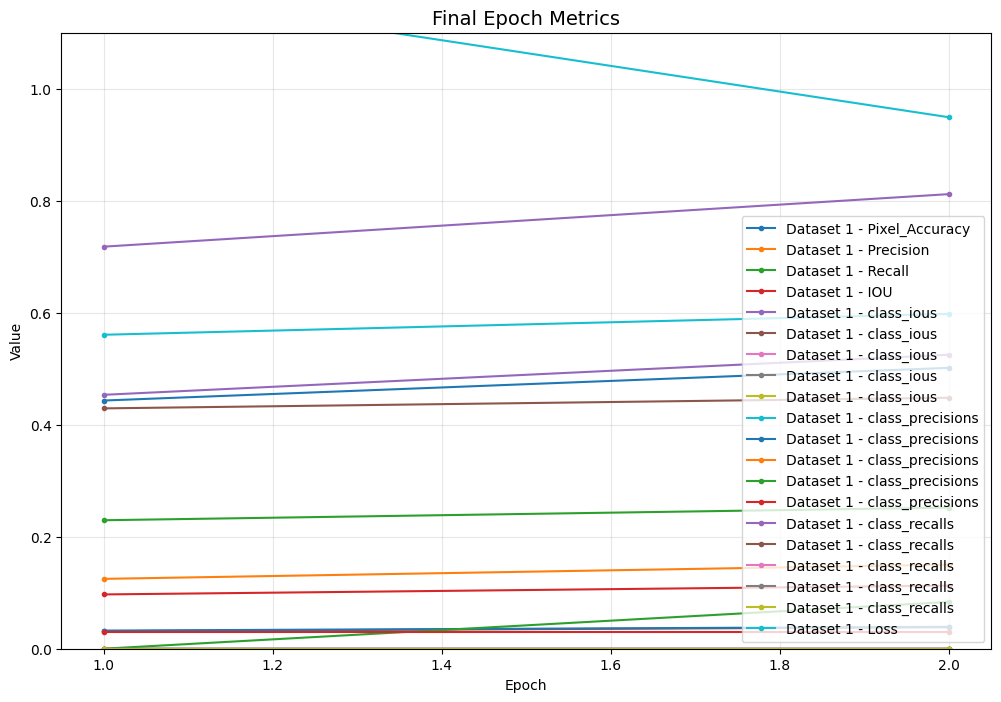

In [12]:
print("\n" + "="*70)
print("TRAINING MAMBAUNET")
print("="*70)

session_mamba = TrainingSession(
    model=mamba_model,
    trainLoader=train_loader,
    testLoader=[val_loader],
    lossFunc=loss_fn,
    init_lr=1e-4,
    num_epochs=2,
    experiment_name="MambaUNet_Landcover_5class",
)

session_mamba.scaler = None  # Disable mixed precision for evaluation
session_mamba.learn()

## 13: Train ResNet_UNet Baseline

2025-11-12 23:50:05,876 - INFO - Starting training: 2 epochs
2025-11-12 23:50:05,877 - INFO - Model parameters: 15,908,650



TRAINING RESNET_UNET BASELINE
Using CUDA device.


Epoch 1/2:   0%|          | 0/934 [00:00<?, ?it/s]

Epoch 1/2: 100%|██████████| 934/934 [1:14:10<00:00,  4.76s/it, loss=0.0867, lr=0.000100]
2025-11-13 01:20:03,454 - INFO - Epoch   1 | Train Loss: 0.3176 | Val Loss: 0.3902 | Avg Metric: 0.2188
2025-11-13 01:20:03,455 - INFO -   Dataset 1: {'Pixel_Accuracy': 0.6011824821358296, 'Precision': 0.29136172143792544, 'Recall': 0.47989086521263885, 'IOU': 0.2187554773201964, 'class_ious': [0.6214505790255556, 0.07841214038135104, 4.6167553017002506e-06, 0.2144507685311623, 0.17945928190761265], 'class_precisions': [0.6743279014869282, 0.07862460395536705, 0.25416783817965, 0.24890574294877116, 0.20078252061891058], 'class_recalls': [0.8713297007688835, 0.4759425687330279, 4.6167620437256515e-06, 0.3600930261658215, 0.6920844136334178], 'Loss': 0.3901721196554935}


Epoch   1 | Train Loss: 0.3176 | Val Loss: 0.3902 | Avg Metric: 0.2188


2025-11-13 01:20:04,334 - INFO - New best model saved at epoch 1
Epoch 2/2: 100%|██████████| 934/934 [1:13:23<00:00,  4.71s/it, loss=0.2532, lr=0.000050]
2025-11-13 02:49:19,051 - INFO - Epoch   2 | Train Loss: 0.2532 | Val Loss: 0.3556 | Avg Metric: 0.2448
2025-11-13 02:49:19,052 - INFO -   Dataset 1: {'Pixel_Accuracy': 0.6338224980368543, 'Precision': 0.44326871176223087, 'Recall': 0.4834434960284781, 'IOU': 0.244847305999928, 'class_ious': [0.6386456879108348, 0.07107605537068358, 0.04800722625855743, 0.23062105692094262, 0.23588650353862187], 'class_precisions': [0.6819901011272598, 0.07126723079703544, 0.9117099865158992, 0.2805882108784964, 0.27078802949246206], 'class_recalls': [0.9001481140134346, 0.4811551458206936, 0.048072144617060136, 0.33896753561465226, 0.6488745400765493], 'Loss': 0.3556168720645098}


Epoch   2 | Train Loss: 0.2532 | Val Loss: 0.3556 | Avg Metric: 0.2448


2025-11-13 02:49:19,951 - INFO - New best model saved at epoch 2
2025-11-13 02:49:19,952 - INFO - Training completed! Best metric: 0.2448 at epoch 2


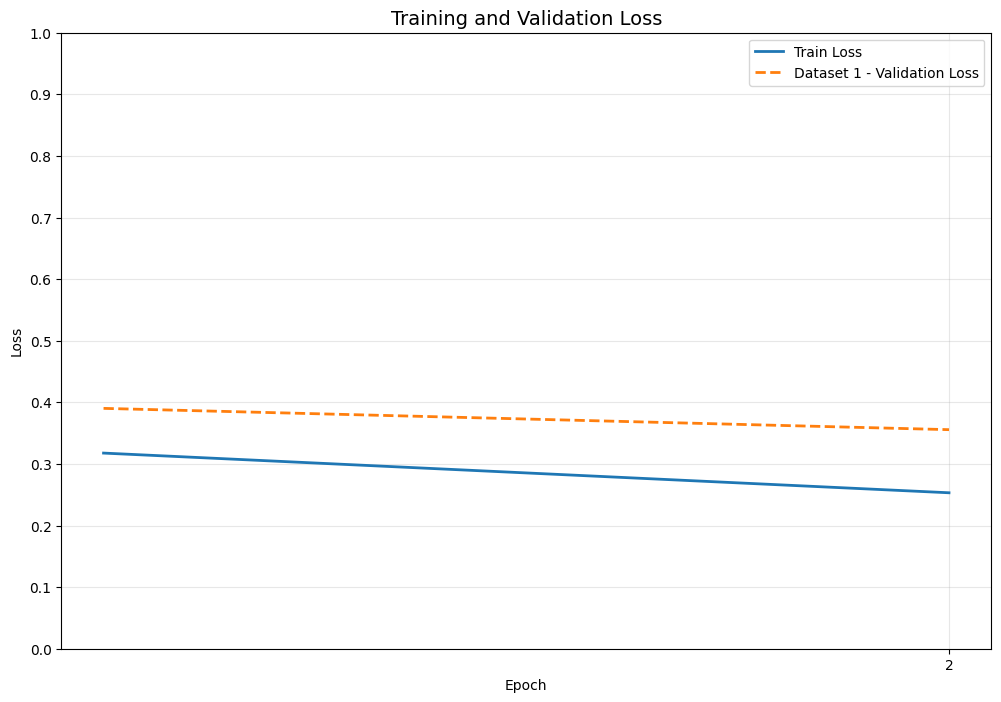

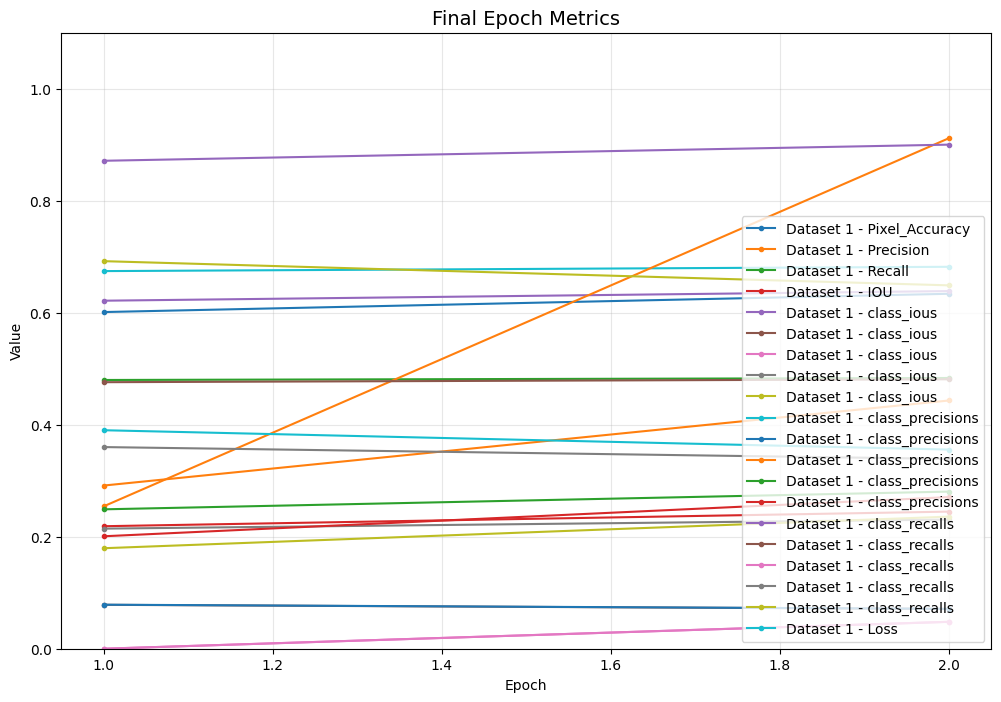

In [14]:
print("\n" + "="*70)
print("TRAINING RESNET_UNET BASELINE")
print("="*70)

session_resnet = TrainingSession(
    model=resnet_model,
    trainLoader=train_loader,
    testLoader=[val_loader],
    lossFunc=loss_fn,
    init_lr=1e-4,
    num_epochs=2,
    experiment_name="ResNet_UNet_Landcover_5class"
)

session_resnet.scaler = None  # Disable mixed precision for evaluation
session_resnet.learn()